# Train a model with MNIST dataset to have a good accuracy>95% with few parameters

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train a model with MNIST dataset to have a good accuracy>95% with few parameters

In [16]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

In [17]:
train_data = datasets.MNIST("../data", train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST("../data", train=True, download=True, transform=train_transforms)

In [18]:
batch_size = 512
kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

Let us visualize few sample images

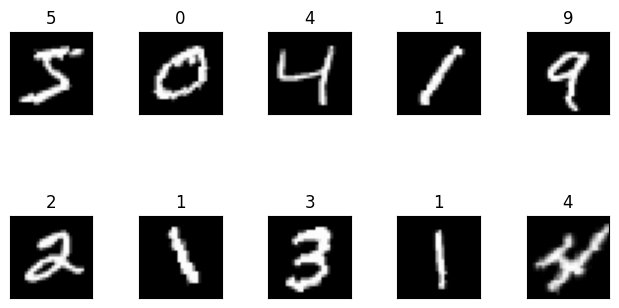

In [19]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [20]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Define the model

In [42]:
class Net(nn.Module):
    #This defines the structure of the NN.
    # Total params: 160 + 4640 + 18785 + 660 ≈ 24,245
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3,padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2   = nn.BatchNorm2d(32)
        self.fc    = nn.Linear(32 * 6 * 6, 65)
        self.fc2   = nn.Linear(65, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [43]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

.

In [44]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
print("Current LR:", scheduler.get_last_lr())

# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 12, 12]           4,640
       BatchNorm2d-4           [-1, 32, 12, 12]              64
            Linear-5                   [-1, 65]          74,945
           Dropout-6                   [-1, 65]               0
            Linear-7                   [-1, 10]             660
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.31
Estimated Total Size (MB): 0.57
----------------------------------------------------------------
Current LR: [0.01]
Epoch 1


Train: Loss=0.2900 Batch_id=117 Accuracy=88.91: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]


Test set: Average loss: 0.0002, Accuracy: 58101/60000 (96.83%)

Epoch 2


Train: Loss=0.1681 Batch_id=117 Accuracy=96.41: 100%|██████████| 118/118 [00:18<00:00,  6.37it/s]


Test set: Average loss: 0.0001, Accuracy: 58686/60000 (97.81%)

Epoch 3


Train: Loss=0.1877 Batch_id=117 Accuracy=97.02: 100%|██████████| 118/118 [00:19<00:00,  6.11it/s]


Test set: Average loss: 0.0001, Accuracy: 58848/60000 (98.08%)

Epoch 4


Train: Loss=0.1169 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:19<00:00,  5.98it/s]


Test set: Average loss: 0.0001, Accuracy: 58864/60000 (98.11%)

Epoch 5


Train: Loss=0.1571 Batch_id=117 Accuracy=97.44: 100%|██████████| 118/118 [00:19<00:00,  6.01it/s]


Test set: Average loss: 0.0001, Accuracy: 58921/60000 (98.20%)

Epoch 6


Train: Loss=0.1785 Batch_id=117 Accuracy=97.64: 100%|██████████| 118/118 [00:18<00:00,  6.27it/s]


Test set: Average loss: 0.0001, Accuracy: 59089/60000 (98.48%)

Epoch 7


Train: Loss=0.2118 Batch_id=117 Accuracy=97.72: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Test set: Average loss: 0.0001, Accuracy: 58903/60000 (98.17%)

Epoch 8


Train: Loss=0.2236 Batch_id=117 Accuracy=97.97: 100%|██████████| 118/118 [00:18<00:00,  6.34it/s]


Test set: Average loss: 0.0001, Accuracy: 59092/60000 (98.49%)

Epoch 9


Train: Loss=0.1702 Batch_id=117 Accuracy=98.02: 100%|██████████| 118/118 [00:18<00:00,  6.32it/s]


Test set: Average loss: 0.0001, Accuracy: 59151/60000 (98.58%)

Epoch 10


Train: Loss=0.1481 Batch_id=117 Accuracy=98.07: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


Test set: Average loss: 0.0001, Accuracy: 59184/60000 (98.64%)

Epoch 11


Train: Loss=0.0523 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:19<00:00,  6.09it/s]


Test set: Average loss: 0.0001, Accuracy: 59292/60000 (98.82%)

Epoch 12


Train: Loss=0.2520 Batch_id=117 Accuracy=98.01: 100%|██████████| 118/118 [00:19<00:00,  6.06it/s]


Test set: Average loss: 0.0001, Accuracy: 59084/60000 (98.47%)

Epoch 13


Train: Loss=0.1410 Batch_id=117 Accuracy=98.08: 100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


Test set: Average loss: 0.0001, Accuracy: 59266/60000 (98.78%)

Epoch 14


Train: Loss=0.1683 Batch_id=117 Accuracy=98.07: 100%|██████████| 118/118 [00:18<00:00,  6.47it/s]


Test set: Average loss: 0.0001, Accuracy: 59317/60000 (98.86%)

Epoch 15


Train: Loss=0.2203 Batch_id=117 Accuracy=98.20: 100%|██████████| 118/118 [00:18<00:00,  6.39it/s]


Test set: Average loss: 0.0001, Accuracy: 59274/60000 (98.79%)

Epoch 16


Train: Loss=0.0991 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:18<00:00,  6.22it/s]


Test set: Average loss: 0.0000, Accuracy: 59525/60000 (99.21%)

Epoch 17


Train: Loss=0.0783 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


Test set: Average loss: 0.0000, Accuracy: 59572/60000 (99.29%)

Epoch 18


Train: Loss=0.1065 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:19<00:00,  6.07it/s]


Test set: Average loss: 0.0000, Accuracy: 59633/60000 (99.39%)

Epoch 19


Train: Loss=0.1076 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:18<00:00,  6.36it/s]


Test set: Average loss: 0.0000, Accuracy: 59586/60000 (99.31%)

Epoch 20


Train: Loss=0.0268 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:18<00:00,  6.41it/s]


Test set: Average loss: 0.0000, Accuracy: 59603/60000 (99.34%)

